In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState

##### Carregando o dataset

In [80]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [81]:
X_train = df_train.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

##### Declarando as funções de metricas

In [82]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [83]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [84]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [85]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Criando o modelo MLP

In [86]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(2, activation='softmax')
])

In [87]:
model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [88]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [89]:
model.summary()

Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_453 (Dense)               │ (None, 50)             │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852 (7.23 KB)

 Trainable params: 1,852 (7.23 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
history = model.fit(
    X_train,
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step - accuracy: 0.8245 - loss: 0.4007 - val_accuracy: 0.9051 - val_loss: 0.2458
Epoch 2/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step - accuracy: 0.9028 - loss: 0.2462 - val_accuracy: 0.9242 - val_loss: 0.1924
Epoch 3/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9206 - loss: 0.1974 - val_accuracy: 0.9328 - val_loss: 0.1690
Epoch 4/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - accuracy: 0.9251 - loss: 0.1809 - val_accuracy: 0.9368 - val_loss: 0.1550
Epoch 5/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9314 - loss: 0.1652 - val_accuracy: 0.9407 - val_loss: 0.1468
Epoch 6/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9328 - loss: 0.1600 - val_accuracy: 0.9384 - val_loss: 0.1455
Epoch 7/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9361 - loss: 0.1512 - val_accuracy: 0.9418 - val_loss: 0.1396
Epoch 8/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9359 - loss: 0.1

##### Avaliando o modelo

In [91]:
mlp_pred_scores = model.predict(X_test)
mlp_pred_class = np.argmax(mlp_pred_scores, axis=1)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


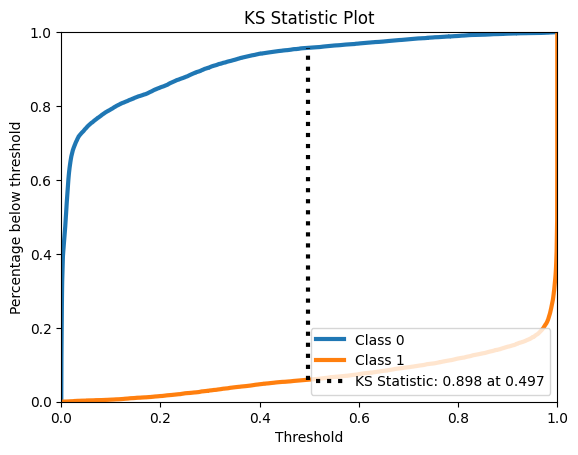



Multi Layer Perceptron - Test

Accuracy:         0.9502
Recall:           0.9405
Precision:        0.9447
F1:               0.9426
AUROC:            0.9910
AUPR:             0.9896


In [92]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('\n\nMulti Layer Perceptron - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

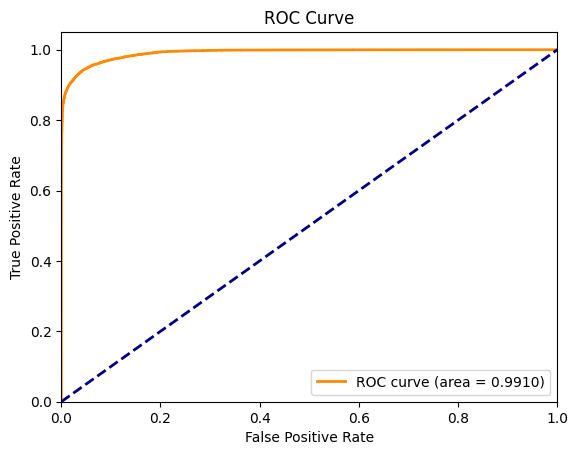

In [93]:
plot_roc_curve(mlp_pred_scores, y_test)

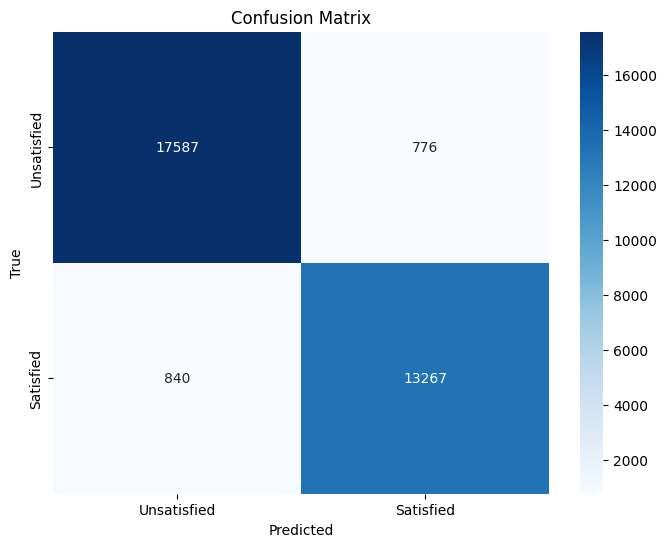

In [94]:
plot_confusion_matrix(y_pred=mlp_pred_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC e o K-S

In [100]:
def objective(trial):

    global x_train
    global y_train

    global X_val
    global y_val

    global X_test
    global y_test

    global early_stopping
    
    params = {
        'n_hidden_layers': trial.suggest_int('n_hidden_layers', 10, 500, step=10),
        'activation_function' : trial.suggest_categorical('activation_function', ['relu', 'sigmoid', 'softmax', 'tanh']),
        'optimizer' : trial.suggest_categorical('optimizer', ['adam', 'SGD', 'rmsprop']),
        'batch_size': trial.suggest_int('batch_size', 32, 160, step=32),
        'dropout': trial.suggest_int('dropout', 0, 80, step=10)
    }

    trial.set_user_attr("n_hidden_layers", params["n_hidden_layers"])
    trial.set_user_attr("activation_function", params["activation_function"])
    trial.set_user_attr("optimizer", params["optimizer"])
    trial.set_user_attr("batch_size", params["batch_size"])
    trial.set_user_attr("dropout", params["dropout"])

    model = Sequential([
        # Input layer
        Input(shape=(X_train.shape[1],)),

        # Hidden layers
        Dense(params['n_hidden_layers'], activation=params['activation_function']),
        Dropout(params['dropout']/100),

        # Output layer
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=params['optimizer'], 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    history = model.fit(
        X_train,
        y_train, 
        epochs=100, 
        batch_size=params['batch_size'], 
        validation_data=(X_val, y_val), 
        callbacks=[early_stopping]
    )

    y_pred_test_scores = model.predict(X_test)
    y_pred_test_class = np.argmax(y_pred_test_scores, axis=1)
    
    # Avaliar o modelo usando test k-s
    # y_pred_test_scores = model.predict(X_test, batch_size=params['batch_size'])
    # prob_class_0 = 1 - y_pred_test_scores

    # y_pred_test_scores = np.hstack((prob_class_0, y_pred_test_scores))
    # y_pred_test_class = np.argmax(y_pred_test_scores, axis=1)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, y_pred_test_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nMLP\nn_hidden_layers: {params["n_hidden_layers"]}\nactivation_function:{params["activation_function"]}\noptimizer:{params["optimizer"]}\nbatch_size:{params["batch_size"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    return auroc, ks_statistic


[I 2024-07-29 19:39:56,363] A new study created in memory with name: no-name-9a6abd42-148e-4f6d-9868-44392ab9d3bf


Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5241 - loss: 0.8118 - val_accuracy: 0.8025 - val_loss: 0.6387
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5817 - loss: 0.6754 - val_accuracy: 0.7960 - val_loss: 0.6244
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6133 - loss: 0.6538 - val_accuracy: 0.8012 - val_loss: 0.6096
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6330 - loss: 0.6410 - val_accuracy: 0.8001 - val_loss: 0.5928
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6481 - loss: 0.6272 - val_accuracy: 0.8020 - val_loss: 0.5751
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step


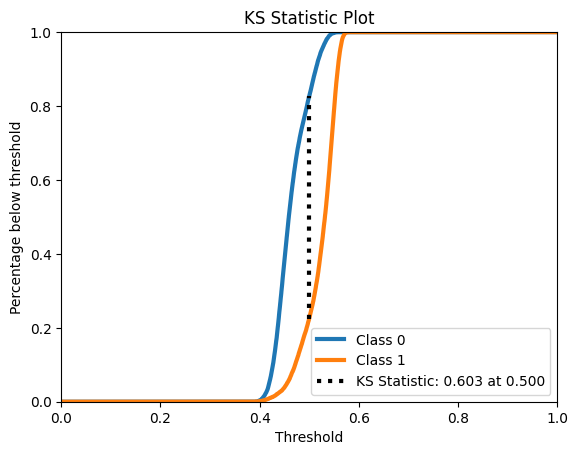

[I 2024-07-29 19:40:01,537] Trial 0 finished with values: [0.8821696401231158, 0.6027084074729172] and parameters: {'n_hidden_layers': 60, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 160, 'dropout': 70}. 




MLP
n_hidden_layers: 60
activation_function:sigmoid
optimizer:SGD
batch_size:160

Accuracy:         0.8047
Recall:           0.7749
Precision:        0.7755
F1:               0.7752
AUROC:            0.8822
AUPR:             0.8732
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7066 - loss: 0.6176 - val_accuracy: 0.8334 - val_loss: 0.4359
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8178 - loss: 0.4527 - val_accuracy: 0.8587 - val_loss: 0.3714
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8439 - loss: 0.4051 - val_accuracy: 0.8641 - val_loss: 0.3501
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8476 - loss: 0.3887 - val_accuracy: 0.8670 - val_loss: 0.3376
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8517 - loss: 0.3789 - val_accuracy: 0.8711 - val_loss: 0.3287
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


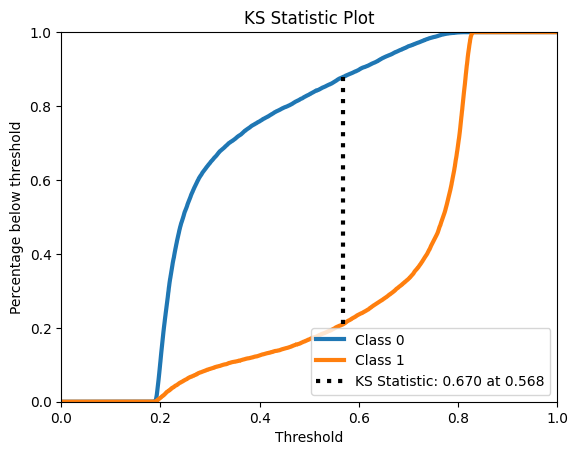

[I 2024-07-29 19:40:15,454] Trial 1 finished with values: [0.9069927106349079, 0.669531422697411] and parameters: {'n_hidden_layers': 390, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 64, 'dropout': 80}. 




MLP
n_hidden_layers: 390
activation_function:softmax
optimizer:adam
batch_size:64

Accuracy:         0.8314
Recall:           0.8315
Precision:        0.7911
F1:               0.8108
AUROC:            0.9070
AUPR:             0.9090
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8417 - loss: 0.3820 - val_accuracy: 0.8702 - val_loss: 0.3368
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8664 - loss: 0.3410 - val_accuracy: 0.8719 - val_loss: 0.3083
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8813 - loss: 0.2950 - val_accuracy: 0.9011 - val_loss: 0.2446
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8939 - loss: 0.2584 - val_accuracy: 0.9091 - val_loss: 0.2203
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9004 - loss: 0.2431 - val_accuracy: 0.9137 - val_loss: 0.2098
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


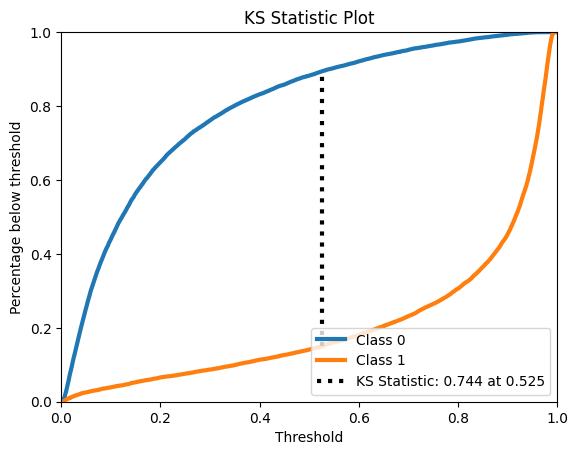

[I 2024-07-29 19:40:48,098] Trial 2 finished with values: [0.9289286662252715, 0.7436371131041896] and parameters: {'n_hidden_layers': 230, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 10}. 




MLP
n_hidden_layers: 230
activation_function:tanh
optimizer:rmsprop
batch_size:32

Accuracy:         0.8720
Recall:           0.8587
Precision:        0.8485
F1:               0.8536
AUROC:            0.9289
AUPR:             0.9326
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8224 - loss: 0.4074 - val_accuracy: 0.8678 - val_loss: 0.3421
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8630 - loss: 0.3507 - val_accuracy: 0.8678 - val_loss: 0.3422
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8594 - loss: 0.3544 - val_accuracy: 0.8725 - val_loss: 0.3432
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8662 - loss: 0.3498 - val_accuracy: 0.8673 - val_loss: 0.3378
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8648 - loss: 0.3463 - val_accuracy: 0.8695 - val_loss: 0.3315
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


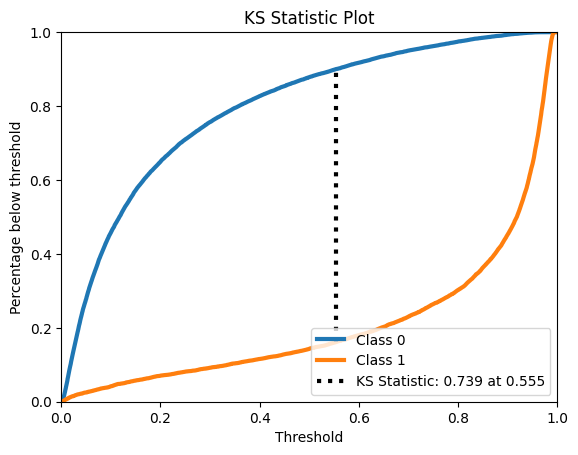

[I 2024-07-29 19:41:08,162] Trial 3 finished with values: [0.9271010759015588, 0.7387540502761816] and parameters: {'n_hidden_layers': 440, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 30}. 




MLP
n_hidden_layers: 440
activation_function:tanh
optimizer:adam
batch_size:160

Accuracy:         0.8690
Recall:           0.8570
Precision:        0.8440
F1:               0.8504
AUROC:            0.9271
AUPR:             0.9310
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4810 - loss: 0.6933 - val_accuracy: 0.4971 - val_loss: 0.6933
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4840 - loss: 0.6933 - val_accuracy: 0.4513 - val_loss: 0.6932
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4928 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5024 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5084 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


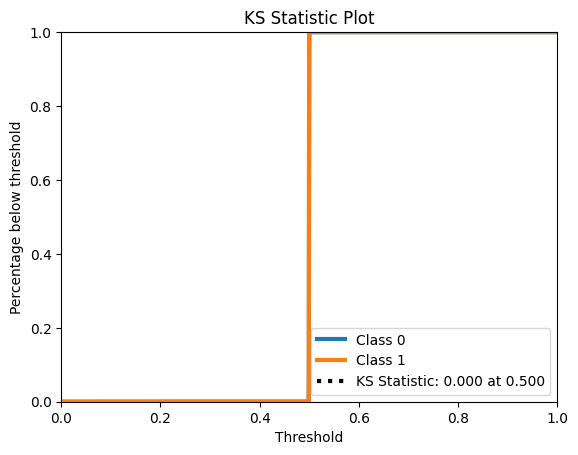

[I 2024-07-29 19:41:25,897] Trial 4 finished with values: [0.36104033015403575, 4.41194339829698e-05] and parameters: {'n_hidden_layers': 290, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 128, 'dropout': 10}. 




MLP
n_hidden_layers: 290
activation_function:softmax
optimizer:SGD
batch_size:128

Accuracy:         0.5617
Recall:           0.0018
Precision:        0.1461
F1:               0.0036
AUROC:            0.3610
AUPR:             0.3496
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7175 - loss: 0.6301 - val_accuracy: 0.8043 - val_loss: 0.5025
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.8021 - loss: 0.4845 - val_accuracy: 0.8176 - val_loss: 0.4362
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.8142 - loss: 0.4314 - val_accuracy: 0.8304 - val_loss: 0.4159
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.8274 - loss: 0.4081 - val_accuracy: 0.8434 - val_loss: 0.3912
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.8387 - loss: 0.3892 - val_accuracy: 0.8468 - val_loss: 0.3779
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step


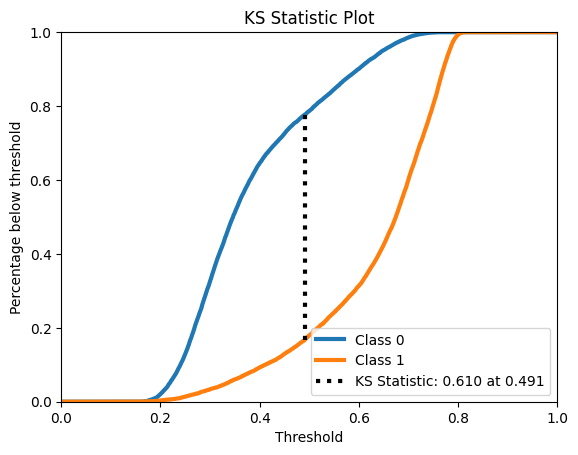

[I 2024-07-29 19:41:32,172] Trial 5 finished with values: [0.8851361036284554, 0.609966338095588] and parameters: {'n_hidden_layers': 280, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 96, 'dropout': 0}. 




MLP
n_hidden_layers: 280
activation_function:sigmoid
optimizer:SGD
batch_size:96

Accuracy:         0.8011
Recall:           0.8201
Precision:        0.7469
F1:               0.7818
AUROC:            0.8851
AUPR:             0.8748
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.7211 - loss: 0.6182 - val_accuracy: 0.8025 - val_loss: 0.4731
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8010 - loss: 0.4590 - val_accuracy: 0.8228 - val_loss: 0.4168
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.8223 - loss: 0.4132 - val_accuracy: 0.8375 - val_loss: 0.3912
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.8377 - loss: 0.3897 - val_accuracy: 0.8444 - val_loss: 0.3772
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8456 - loss: 0.3780 - val_accuracy: 0.8532 - val_loss: 0.3666
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step


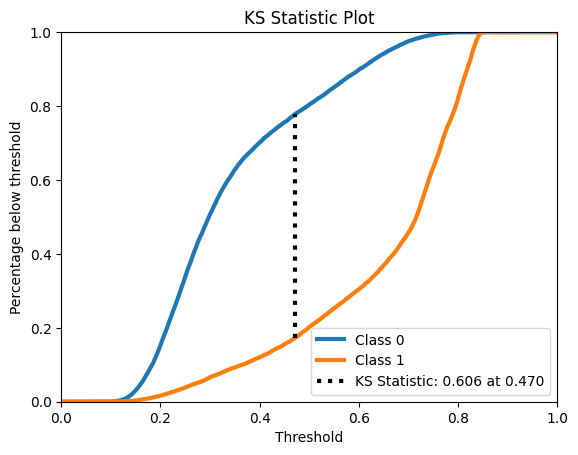

[I 2024-07-29 19:41:38,470] Trial 6 finished with values: [0.8856619448217861, 0.606175556489415] and parameters: {'n_hidden_layers': 170, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 64, 'dropout': 0}. 




MLP
n_hidden_layers: 170
activation_function:sigmoid
optimizer:SGD
batch_size:64

Accuracy:         0.8013
Recall:           0.7980
Precision:        0.7576
F1:               0.7773
AUROC:            0.8857
AUPR:             0.8817
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8310 - loss: 0.3938 - val_accuracy: 0.9058 - val_loss: 0.2337
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8971 - loss: 0.2614 - val_accuracy: 0.9230 - val_loss: 0.2008
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9086 - loss: 0.2258 - val_accuracy: 0.9303 - val_loss: 0.1782
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9127 - loss: 0.2133 - val_accuracy: 0.9318 - val_loss: 0.1682
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9178 - loss: 0.2011 - val_accuracy: 0.9348 - val_loss: 0.1575
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step


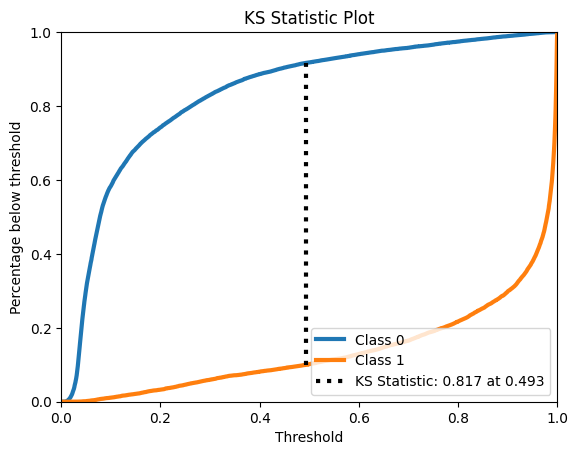

[I 2024-07-29 19:41:54,779] Trial 7 finished with values: [0.9682744403742796, 0.8171059341349003] and parameters: {'n_hidden_layers': 470, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 80}. 




MLP
n_hidden_layers: 470
activation_function:relu
optimizer:adam
batch_size:32

Accuracy:         0.9095
Recall:           0.8984
Precision:        0.8938
F1:               0.8961
AUROC:            0.9683
AUPR:             0.9649
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7908 - loss: 0.5128 - val_accuracy: 0.8713 - val_loss: 0.3305
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8651 - loss: 0.3393 - val_accuracy: 0.8773 - val_loss: 0.3005
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8793 - loss: 0.2999 - val_accuracy: 0.8988 - val_loss: 0.2556
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8976 - loss: 0.2628 - val_accuracy: 0.9102 - val_loss: 0.2306
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9039 - loss: 0.2450 - val_accuracy: 0.9145 - val_loss: 0.2166
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


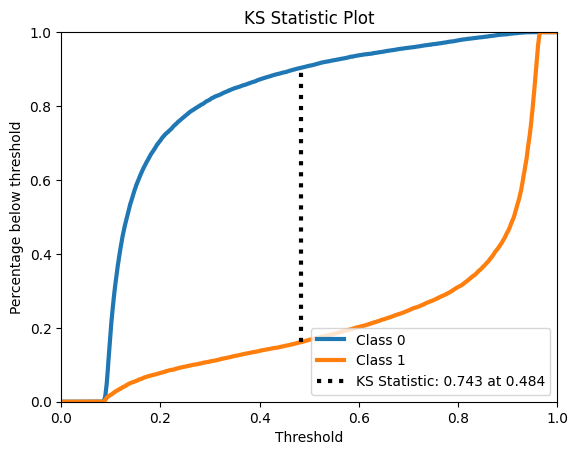

[I 2024-07-29 19:42:12,954] Trial 8 finished with values: [0.9288870231774029, 0.7426646403304334] and parameters: {'n_hidden_layers': 420, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 10}. 




MLP
n_hidden_layers: 420
activation_function:softmax
optimizer:adam
batch_size:32

Accuracy:         0.8755
Recall:           0.8322
Precision:        0.8751
F1:               0.8531
AUROC:            0.9289
AUPR:             0.9332
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7537 - loss: 0.4991 - val_accuracy: 0.8645 - val_loss: 0.3570
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8509 - loss: 0.3713 - val_accuracy: 0.8642 - val_loss: 0.3490
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8576 - loss: 0.3622 - val_accuracy: 0.8658 - val_loss: 0.3470
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8585 - loss: 0.3619 - val_accuracy: 0.8668 - val_loss: 0.3437
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8625 - loss: 0.3536 - val_accuracy: 0.8648 - val_loss: 0.3416
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


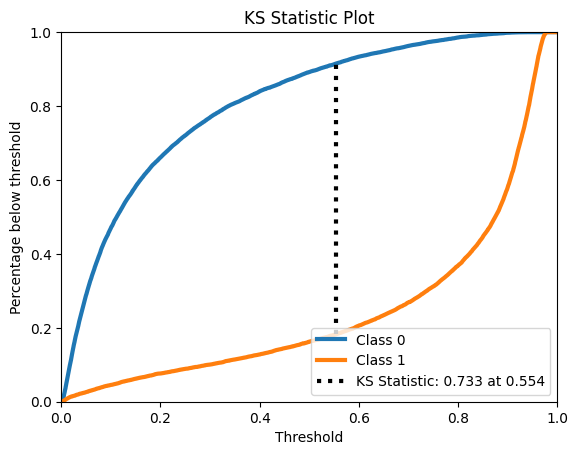

[I 2024-07-29 19:42:17,871] Trial 9 finished with values: [0.9244688048521696, 0.7327585863129673] and parameters: {'n_hidden_layers': 260, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 20}. 




MLP
n_hidden_layers: 260
activation_function:sigmoid
optimizer:adam
batch_size:160

Accuracy:         0.8683
Recall:           0.8375
Precision:        0.8562
F1:               0.8467
AUROC:            0.9245
AUPR:             0.9288
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7094 - loss: 0.5575 - val_accuracy: 0.8328 - val_loss: 0.3983
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8217 - loss: 0.4188 - val_accuracy: 0.8525 - val_loss: 0.3623
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.8442 - loss: 0.3825 - val_accuracy: 0.8661 - val_loss: 0.3453
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.8514 - loss: 0.3663 - val_accuracy: 0.8682 - val_loss: 0.3319
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.8597 - loss: 0.3515 - val_accuracy: 0.8717 - val_loss: 0.3232
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step


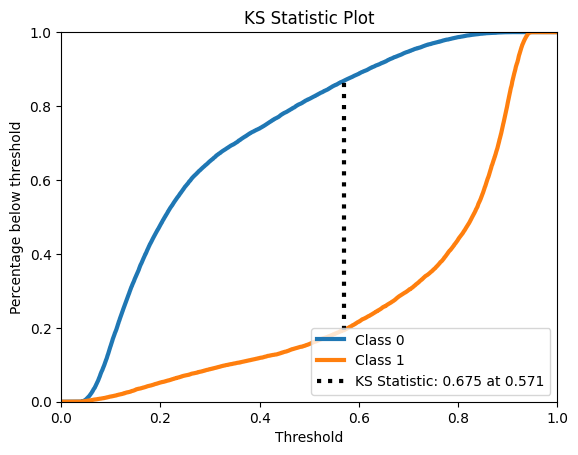

[I 2024-07-29 19:42:24,086] Trial 10 finished with values: [0.9082439804776465, 0.6751763322989142] and parameters: {'n_hidden_layers': 410, 'activation_function': 'relu', 'optimizer': 'SGD', 'batch_size': 96, 'dropout': 70}. 




MLP
n_hidden_layers: 410
activation_function:relu
optimizer:SGD
batch_size:96

Accuracy:         0.8300
Recall:           0.8441
Precision:        0.7819
F1:               0.8118
AUROC:            0.9082
AUPR:             0.9096
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7379 - loss: 0.6136 - val_accuracy: 0.8367 - val_loss: 0.4100
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.8319 - loss: 0.4115 - val_accuracy: 0.8630 - val_loss: 0.3441
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.8528 - loss: 0.3689 - val_accuracy: 0.8722 - val_loss: 0.3255
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.8608 - loss: 0.3524 - val_accuracy: 0.8763 - val_loss: 0.3144
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8618 - loss: 0.3448 - val_accuracy: 0.8806 - val_loss: 0.3031
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


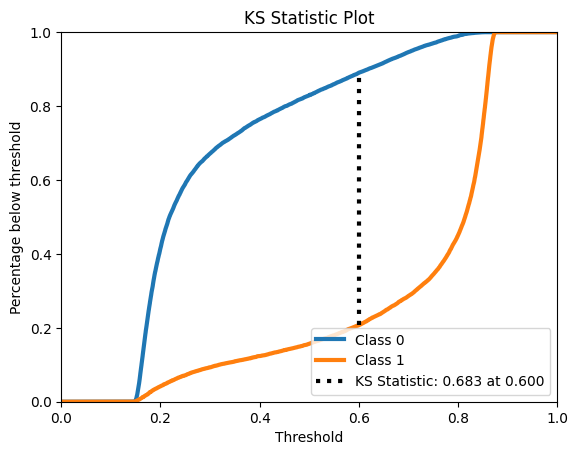

[I 2024-07-29 19:42:32,452] Trial 11 finished with values: [0.9108255946653294, 0.683387951447746] and parameters: {'n_hidden_layers': 150, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 30}. 




MLP
n_hidden_layers: 150
activation_function:softmax
optimizer:rmsprop
batch_size:64

Accuracy:         0.8350
Recall:           0.8429
Precision:        0.7910
F1:               0.8162
AUROC:            0.9108
AUPR:             0.9135
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8551 - loss: 0.3443 - val_accuracy: 0.9110 - val_loss: 0.2184
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step - accuracy: 0.9178 - loss: 0.2035 - val_accuracy: 0.9277 - val_loss: 0.1830
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9290 - loss: 0.1710 - val_accuracy: 0.9379 - val_loss: 0.1530
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9346 - loss: 0.1577 - val_accuracy: 0.9400 - val_loss: 0.1428
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step - accuracy: 0.9379 - loss: 0.1476 - val_accuracy: 0.9442 - val_loss: 0.1357
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step


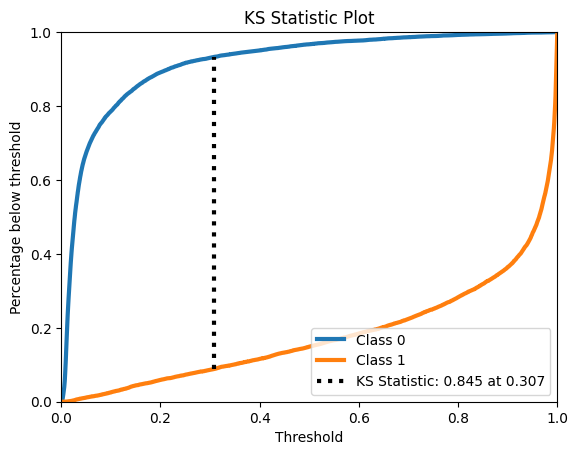

[I 2024-07-29 19:42:45,130] Trial 12 finished with values: [0.9769730197173104, 0.8447202257139279] and parameters: {'n_hidden_layers': 200, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 20}. 




MLP
n_hidden_layers: 200
activation_function:relu
optimizer:rmsprop
batch_size:32

Accuracy:         0.9167
Recall:           0.8509
Precision:        0.9522
F1:               0.8987
AUROC:            0.9770
AUPR:             0.9736
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6053 - loss: 0.6614 - val_accuracy: 0.8151 - val_loss: 0.4785
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.4802 - val_accuracy: 0.8480 - val_loss: 0.3867
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8368 - loss: 0.4027 - val_accuracy: 0.8636 - val_loss: 0.3483
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8509 - loss: 0.3762 - val_accuracy: 0.8686 - val_loss: 0.3334
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8540 - loss: 0.3634 - val_accuracy: 0.8712 - val_loss: 0.3260
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step


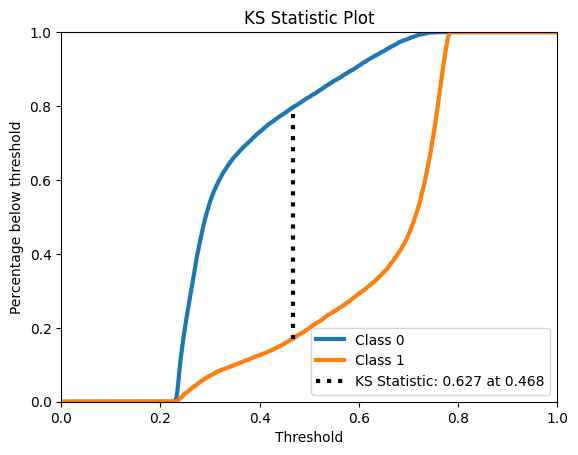

[I 2024-07-29 19:42:51,369] Trial 13 finished with values: [0.8941283499380717, 0.6269524128263737] and parameters: {'n_hidden_layers': 280, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 96, 'dropout': 40}. 




MLP
n_hidden_layers: 280
activation_function:softmax
optimizer:rmsprop
batch_size:96

Accuracy:         0.8142
Recall:           0.8007
Precision:        0.7780
F1:               0.7892
AUROC:            0.8941
AUPR:             0.8944
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8199 - loss: 0.4192 - val_accuracy: 0.8498 - val_loss: 0.3562
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.3564 - val_accuracy: 0.8691 - val_loss: 0.3442
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8585 - loss: 0.3612 - val_accuracy: 0.8606 - val_loss: 0.3449
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8616 - loss: 0.3532 - val_accuracy: 0.8683 - val_loss: 0.3442
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8622 - loss: 0.3508 - val_accuracy: 0.8672 - val_loss: 0.3422
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step


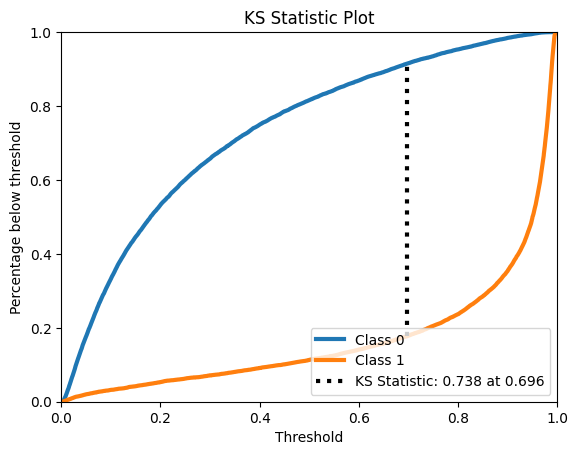

[I 2024-07-29 19:42:57,189] Trial 14 finished with values: [0.9259080117483462, 0.737579810903774] and parameters: {'n_hidden_layers': 450, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 160, 'dropout': 40}. 




MLP
n_hidden_layers: 450
activation_function:tanh
optimizer:rmsprop
batch_size:160

Accuracy:         0.8468
Recall:           0.8869
Precision:        0.7874
F1:               0.8342
AUROC:            0.9259
AUPR:             0.9305
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8191 - loss: 0.4134 - val_accuracy: 0.8698 - val_loss: 0.3436
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8595 - loss: 0.3584 - val_accuracy: 0.8631 - val_loss: 0.3404
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8665 - loss: 0.3468 - val_accuracy: 0.8761 - val_loss: 0.3191
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.8709 - loss: 0.3279 - val_accuracy: 0.8851 - val_loss: 0.2910
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8754 - loss: 0.3103 - val_accuracy: 0.8927 - val_loss: 0.2733
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step


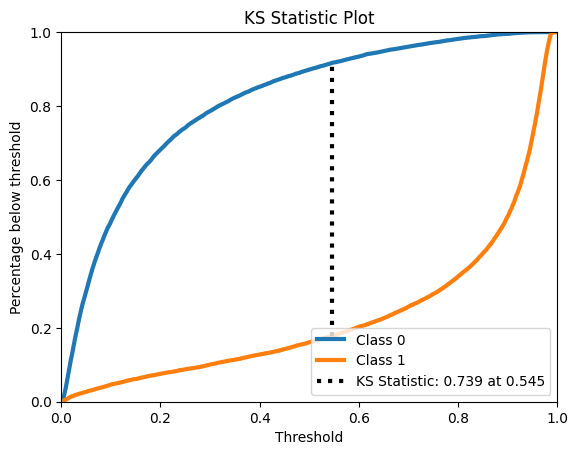

[I 2024-07-29 19:43:05,087] Trial 15 finished with values: [0.927422869055562, 0.7391961788099937] and parameters: {'n_hidden_layers': 140, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 96, 'dropout': 30}. 




MLP
n_hidden_layers: 140
activation_function:tanh
optimizer:adam
batch_size:96

Accuracy:         0.8728
Recall:           0.8390
Precision:        0.8642
F1:               0.8514
AUROC:            0.9274
AUPR:             0.9314
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6534 - loss: 0.6562 - val_accuracy: 0.8125 - val_loss: 0.4994
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7862 - loss: 0.4995 - val_accuracy: 0.8452 - val_loss: 0.4197
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8240 - loss: 0.4425 - val_accuracy: 0.8585 - val_loss: 0.3805
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8399 - loss: 0.4139 - val_accuracy: 0.8613 - val_loss: 0.3604
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8475 - loss: 0.3979 - val_accuracy: 0.8649 - val_loss: 0.3489
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step


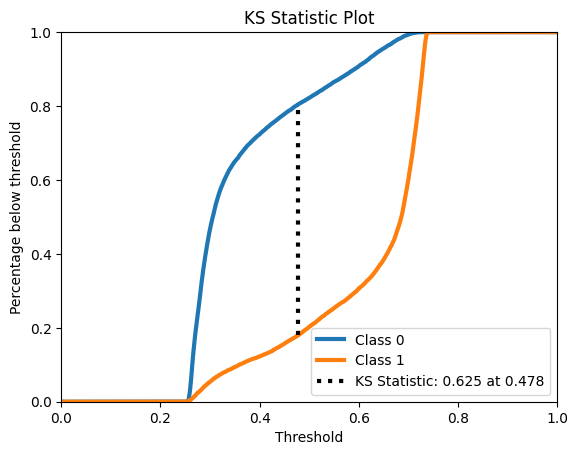

[I 2024-07-29 19:43:11,144] Trial 16 finished with values: [0.8923941674316731, 0.6249254975473721] and parameters: {'n_hidden_layers': 500, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 80}. 




MLP
n_hidden_layers: 500
activation_function:softmax
optimizer:adam
batch_size:160

Accuracy:         0.8114
Recall:           0.7975
Precision:        0.7750
F1:               0.7861
AUROC:            0.8924
AUPR:             0.8888
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7010 - loss: 0.6462 - val_accuracy: 0.8001 - val_loss: 0.5572
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7984 - loss: 0.5377 - val_accuracy: 0.8040 - val_loss: 0.4848
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7993 - loss: 0.4774 - val_accuracy: 0.8099 - val_loss: 0.4477
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.8065 - loss: 0.4442 - val_accuracy: 0.8172 - val_loss: 0.4274
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.8111 - loss: 0.4297 - val_accuracy: 0.8244 - val_loss: 0.4137
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


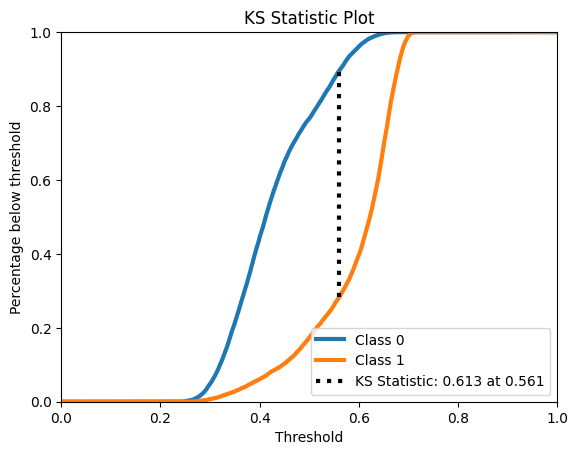

[I 2024-07-29 19:43:15,305] Trial 17 finished with values: [0.8836845958681272, 0.6134369034826408] and parameters: {'n_hidden_layers': 40, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 128, 'dropout': 0}. 




MLP
n_hidden_layers: 40
activation_function:sigmoid
optimizer:SGD
batch_size:128

Accuracy:         0.7922
Recall:           0.8263
Precision:        0.7307
F1:               0.7755
AUROC:            0.8837
AUPR:             0.8827
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6961 - loss: 0.6404 - val_accuracy: 0.8251 - val_loss: 0.4644
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8132 - loss: 0.4658 - val_accuracy: 0.8562 - val_loss: 0.3845
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8407 - loss: 0.4085 - val_accuracy: 0.8644 - val_loss: 0.3554
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8504 - loss: 0.3873 - val_accuracy: 0.8681 - val_loss: 0.3405
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8550 - loss: 0.3759 - val_accuracy: 0.8708 - val_loss: 0.3323
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step


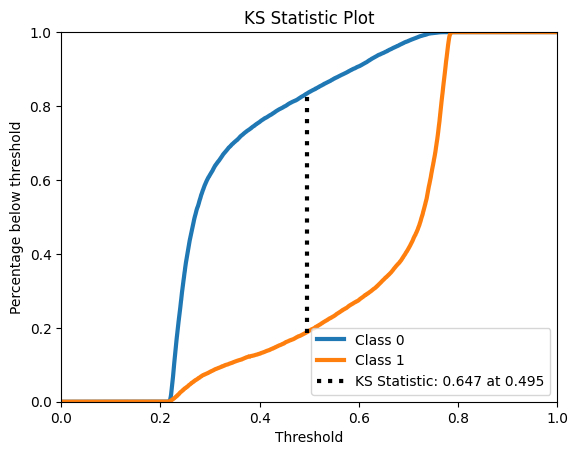

[I 2024-07-29 19:43:23,021] Trial 18 finished with values: [0.9007962926673945, 0.6465245719788568] and parameters: {'n_hidden_layers': 410, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 128, 'dropout': 70}. 




MLP
n_hidden_layers: 410
activation_function:softmax
optimizer:adam
batch_size:128

Accuracy:         0.8248
Recall:           0.8078
Precision:        0.7929
F1:               0.8003
AUROC:            0.9008
AUPR:             0.9000
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.7311 - loss: 0.5359 - val_accuracy: 0.8514 - val_loss: 0.3703
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.8358 - loss: 0.4010 - val_accuracy: 0.8584 - val_loss: 0.3561
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8488 - loss: 0.3803 - val_accuracy: 0.8646 - val_loss: 0.3473
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8528 - loss: 0.3715 - val_accuracy: 0.8682 - val_loss: 0.3400
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8584 - loss: 0.3590 - val_accuracy: 0.8692 - val_loss: 0.3331
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step


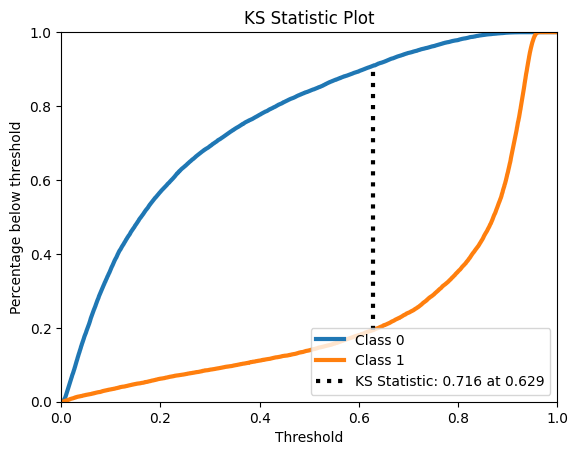

[I 2024-07-29 19:43:29,201] Trial 19 finished with values: [0.9203905578605377, 0.7156986793751328] and parameters: {'n_hidden_layers': 90, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 96, 'dropout': 50}. 




MLP
n_hidden_layers: 90
activation_function:sigmoid
optimizer:rmsprop
batch_size:96

Accuracy:         0.8493
Recall:           0.8608
Precision:        0.8057
F1:               0.8324
AUROC:            0.9204
AUPR:             0.9241
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6457 - loss: 0.6675 - val_accuracy: 0.8227 - val_loss: 0.4112
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.8088 - loss: 0.4461 - val_accuracy: 0.8522 - val_loss: 0.3745
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8318 - loss: 0.4112 - val_accuracy: 0.8589 - val_loss: 0.3604
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8397 - loss: 0.3982 - val_accuracy: 0.8605 - val_loss: 0.3518
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8471 - loss: 0.3840 - val_accuracy: 0.8607 - val_loss: 0.3467
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step


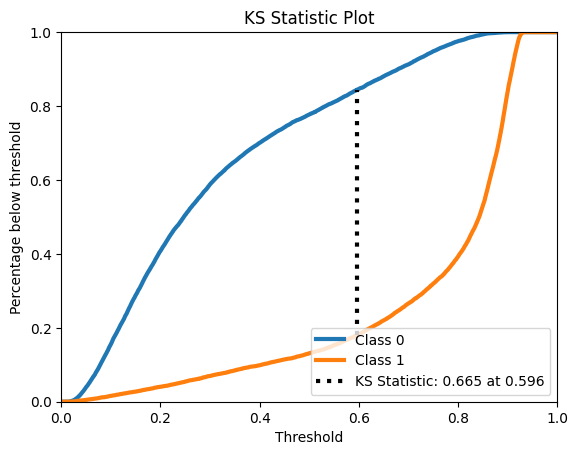

[I 2024-07-29 19:43:33,478] Trial 20 finished with values: [0.9066315944767687, 0.6648971797343787] and parameters: {'n_hidden_layers': 100, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 128, 'dropout': 70}. 




MLP
n_hidden_layers: 100
activation_function:sigmoid
optimizer:adam
batch_size:128

Accuracy:         0.8171
Recall:           0.8689
Precision:        0.7498
F1:               0.8050
AUROC:            0.9066
AUPR:             0.9066
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8357 - loss: 0.3943 - val_accuracy: 0.8707 - val_loss: 0.3433
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8640 - loss: 0.3461 - val_accuracy: 0.8731 - val_loss: 0.3251
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.8708 - loss: 0.3267 - val_accuracy: 0.8927 - val_loss: 0.2813
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.8957 - loss: 0.2716 - val_accuracy: 0.9062 - val_loss: 0.2369
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.9061 - loss: 0.2349 - val_accuracy: 0.9126 - val_loss: 0.2142
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step


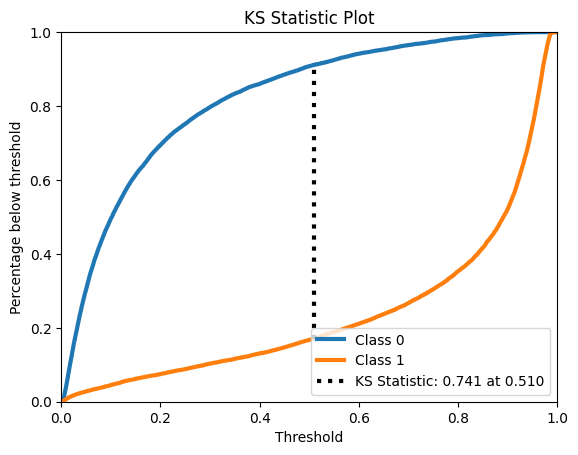

[I 2024-07-29 19:43:38,510] Trial 21 finished with values: [0.9280409464634236, 0.7411658689171199] and parameters: {'n_hidden_layers': 250, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 128, 'dropout': 0}. 




MLP
n_hidden_layers: 250
activation_function:tanh
optimizer:adam
batch_size:128

Accuracy:         0.8751
Recall:           0.8326
Precision:        0.8740
F1:               0.8528
AUROC:            0.9280
AUPR:             0.9320
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8206 - loss: 0.4077 - val_accuracy: 0.8969 - val_loss: 0.2632
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8959 - loss: 0.2595 - val_accuracy: 0.9188 - val_loss: 0.2051
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9103 - loss: 0.2185 - val_accuracy: 0.9298 - val_loss: 0.1800
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9201 - loss: 0.1951 - val_accuracy: 0.9331 - val_loss: 0.1679
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9279 - loss: 0.1783 - val_accuracy: 0.9361 - val_loss: 0.1553
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


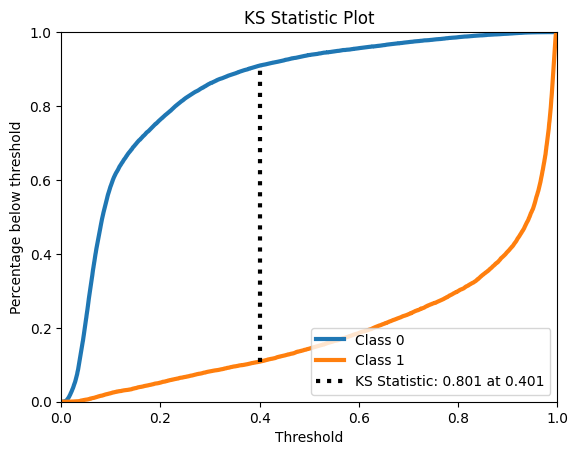

[I 2024-07-29 19:43:42,891] Trial 22 finished with values: [0.9587913504029181, 0.8011984905849519] and parameters: {'n_hidden_layers': 260, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128, 'dropout': 50}. 




MLP
n_hidden_layers: 260
activation_function:relu
optimizer:rmsprop
batch_size:128

Accuracy:         0.9025
Recall:           0.8562
Precision:        0.9140
F1:               0.8841
AUROC:            0.9588
AUPR:             0.9574
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8014 - loss: 0.4449 - val_accuracy: 0.8625 - val_loss: 0.3508
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8553 - loss: 0.3650 - val_accuracy: 0.8687 - val_loss: 0.3449
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8571 - loss: 0.3610 - val_accuracy: 0.8675 - val_loss: 0.3345
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - accuracy: 0.8624 - loss: 0.3441 - val_accuracy: 0.8738 - val_loss: 0.3231
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8675 - loss: 0.3320 - val_accuracy: 0.8816 - val_loss: 0.2952
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step


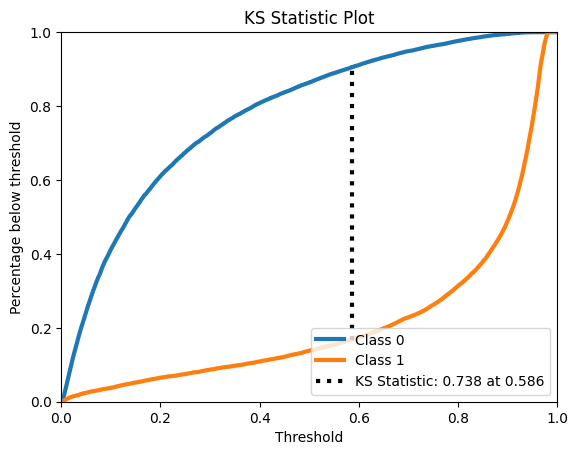

[I 2024-07-29 19:44:00,167] Trial 23 finished with values: [0.926141347927111, 0.7378969504592415] and parameters: {'n_hidden_layers': 370, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 40}. 




MLP
n_hidden_layers: 370
activation_function:sigmoid
optimizer:adam
batch_size:32

Accuracy:         0.8630
Recall:           0.8621
Precision:        0.8293
F1:               0.8454
AUROC:            0.9261
AUPR:             0.9307
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7512 - loss: 0.5308 - val_accuracy: 0.8172 - val_loss: 0.4140
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8195 - loss: 0.4147 - val_accuracy: 0.8497 - val_loss: 0.3751
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8471 - loss: 0.3756 - val_accuracy: 0.8544 - val_loss: 0.3587
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8538 - loss: 0.3632 - val_accuracy: 0.8516 - val_loss: 0.3561
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8560 - loss: 0.3602 - val_accuracy: 0.8615 - val_loss: 0.3477
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


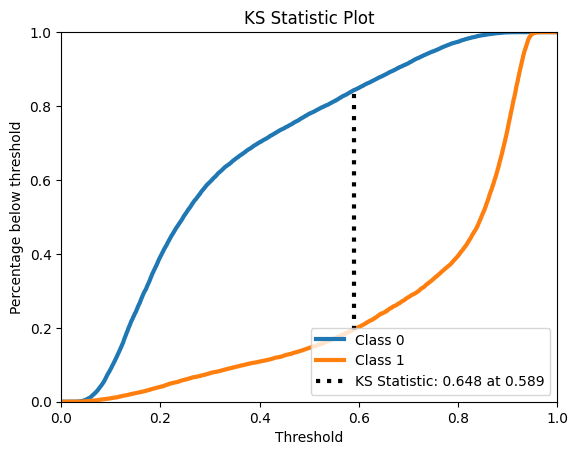

[I 2024-07-29 19:44:05,927] Trial 24 finished with values: [0.9011311336547045, 0.6481645726766457] and parameters: {'n_hidden_layers': 260, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 160, 'dropout': 20}. 




MLP
n_hidden_layers: 260
activation_function:tanh
optimizer:SGD
batch_size:160

Accuracy:         0.8119
Recall:           0.8543
Precision:        0.7483
F1:               0.7978
AUROC:            0.9011
AUPR:             0.9014
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7886 - loss: 0.4637 - val_accuracy: 0.8853 - val_loss: 0.2945
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8761 - loss: 0.3161 - val_accuracy: 0.9040 - val_loss: 0.2461
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8926 - loss: 0.2794 - val_accuracy: 0.9152 - val_loss: 0.2215
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8969 - loss: 0.2630 - val_accuracy: 0.9180 - val_loss: 0.2063
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9036 - loss: 0.2465 - val_accuracy: 0.9249 - val_loss: 0.1939
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step


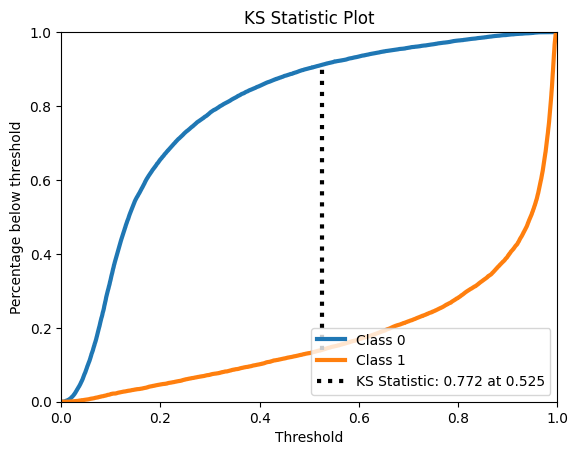

[I 2024-07-29 19:44:21,092] Trial 25 finished with values: [0.9448357874396931, 0.7715711345038174] and parameters: {'n_hidden_layers': 90, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 70}. 




MLP
n_hidden_layers: 90
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.8877
Recall:           0.8686
Precision:        0.8725
F1:               0.8705
AUROC:            0.9448
AUPR:             0.9460
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6649 - loss: 0.6200 - val_accuracy: 0.8309 - val_loss: 0.3996
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8213 - loss: 0.4249 - val_accuracy: 0.8550 - val_loss: 0.3641
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8369 - loss: 0.4005 - val_accuracy: 0.8625 - val_loss: 0.3510
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8457 - loss: 0.3833 - val_accuracy: 0.8620 - val_loss: 0.3433
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8510 - loss: 0.3679 - val_accuracy: 0.8652 - val_loss: 0.3369
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


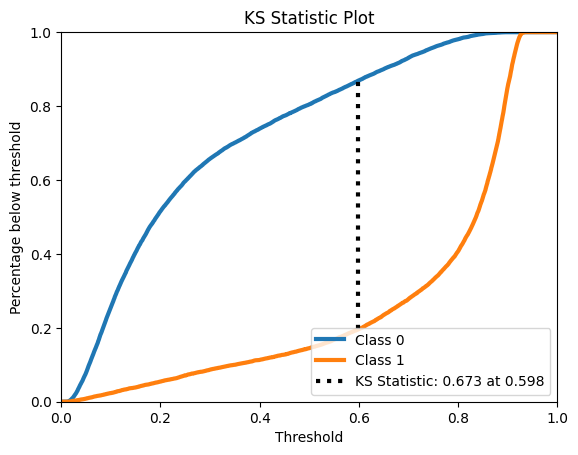

[I 2024-07-29 19:44:29,552] Trial 26 finished with values: [0.9089006165491129, 0.6732684804289893] and parameters: {'n_hidden_layers': 40, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 128, 'dropout': 50}. 




MLP
n_hidden_layers: 40
activation_function:sigmoid
optimizer:rmsprop
batch_size:128

Accuracy:         0.8265
Recall:           0.8552
Precision:        0.7706
F1:               0.8107
AUROC:            0.9089
AUPR:             0.9091
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7740 - loss: 0.5034 - val_accuracy: 0.8696 - val_loss: 0.3269
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8719 - loss: 0.3216 - val_accuracy: 0.8901 - val_loss: 0.2816
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8950 - loss: 0.2696 - val_accuracy: 0.9106 - val_loss: 0.2334
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9122 - loss: 0.2286 - val_accuracy: 0.9155 - val_loss: 0.2174
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9165 - loss: 0.2180 - val_accuracy: 0.9158 - val_loss: 0.2103
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step


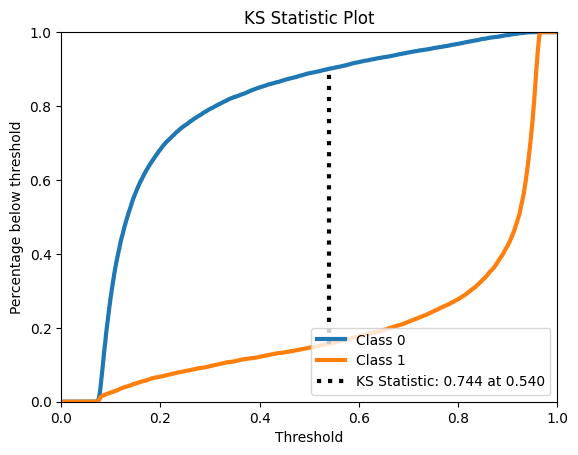

[I 2024-07-29 19:45:03,563] Trial 27 finished with values: [0.9303321286207076, 0.7441405239911805] and parameters: {'n_hidden_layers': 30, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 0}. 




MLP
n_hidden_layers: 30
activation_function:softmax
optimizer:adam
batch_size:32

Accuracy:         0.8736
Recall:           0.8541
Precision:        0.8548
F1:               0.8545
AUROC:            0.9303
AUPR:             0.9341
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8478 - loss: 0.3576 - val_accuracy: 0.9121 - val_loss: 0.2189
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9087 - loss: 0.2240 - val_accuracy: 0.9280 - val_loss: 0.1797
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9194 - loss: 0.1992 - val_accuracy: 0.9320 - val_loss: 0.1650
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9258 - loss: 0.1822 - val_accuracy: 0.9361 - val_loss: 0.1578
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9287 - loss: 0.1746 - val_accuracy: 0.9323 - val_loss: 0.1647
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


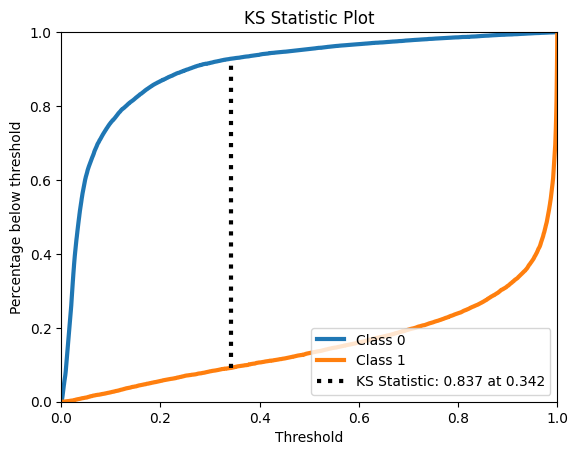

[I 2024-07-29 19:45:35,855] Trial 28 finished with values: [0.9730279667838142, 0.8366887863342058] and parameters: {'n_hidden_layers': 430, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 60}. 




MLP
n_hidden_layers: 430
activation_function:relu
optimizer:rmsprop
batch_size:32

Accuracy:         0.9171
Recall:           0.8683
Precision:        0.9363
F1:               0.9010
AUROC:            0.9730
AUPR:             0.9702
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5517 - loss: 0.7093 - val_accuracy: 0.7994 - val_loss: 0.5728
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6894 - loss: 0.5971 - val_accuracy: 0.7912 - val_loss: 0.5273
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7333 - loss: 0.5465 - val_accuracy: 0.8031 - val_loss: 0.4785
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7547 - loss: 0.5200 - val_accuracy: 0.8089 - val_loss: 0.4586
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7748 - loss: 0.4951 - val_accuracy: 0.8166 - val_loss: 0.4358
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


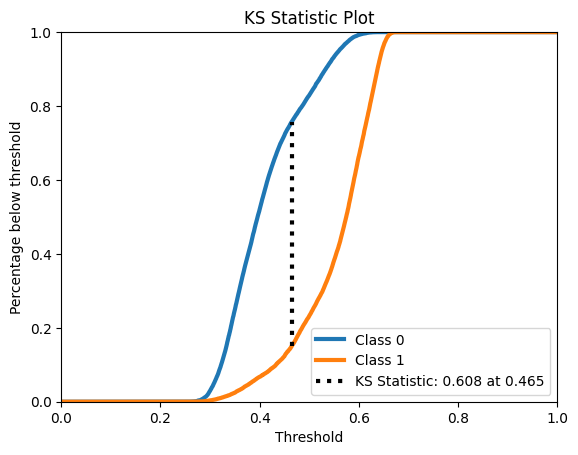

[I 2024-07-29 19:45:49,320] Trial 29 finished with values: [0.8830483518615847, 0.6076623223519642] and parameters: {'n_hidden_layers': 370, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 160, 'dropout': 30}. 




MLP
n_hidden_layers: 370
activation_function:sigmoid
optimizer:SGD
batch_size:160

Accuracy:         0.8028
Recall:           0.7680
Precision:        0.7758
F1:               0.7719
AUROC:            0.8830
AUPR:             0.8735
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7190 - loss: 0.6318 - val_accuracy: 0.8345 - val_loss: 0.4356
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8268 - loss: 0.4378 - val_accuracy: 0.8608 - val_loss: 0.3636
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8498 - loss: 0.3877 - val_accuracy: 0.8682 - val_loss: 0.3411
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8558 - loss: 0.3699 - val_accuracy: 0.8705 - val_loss: 0.3295
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8601 - loss: 0.3623 - val_accuracy: 0.8731 - val_loss: 0.3202
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


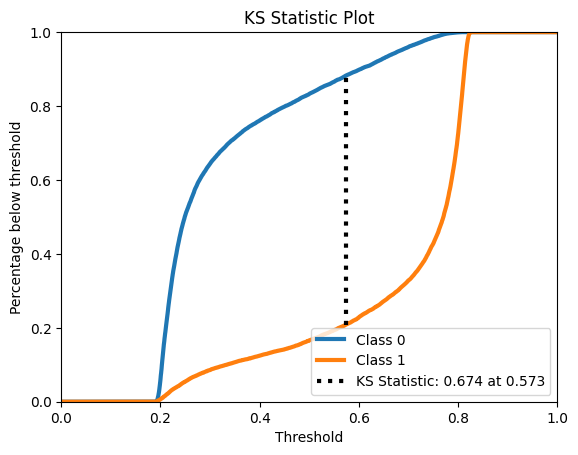

[I 2024-07-29 19:46:04,922] Trial 30 finished with values: [0.908887865959346, 0.6741015923062348] and parameters: {'n_hidden_layers': 410, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 128, 'dropout': 50}. 




MLP
n_hidden_layers: 410
activation_function:softmax
optimizer:adam
batch_size:128

Accuracy:         0.8334
Recall:           0.8343
Precision:        0.7930
F1:               0.8131
AUROC:            0.9089
AUPR:             0.9104
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6055 - loss: 0.6887 - val_accuracy: 0.8138 - val_loss: 0.6022
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7539 - loss: 0.5705 - val_accuracy: 0.8230 - val_loss: 0.4548
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7690 - loss: 0.4741 - val_accuracy: 0.8496 - val_loss: 0.3922
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8062 - loss: 0.4282 - val_accuracy: 0.8613 - val_loss: 0.3600
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8343 - loss: 0.4006 - val_accuracy: 0.8657 - val_loss: 0.3449
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


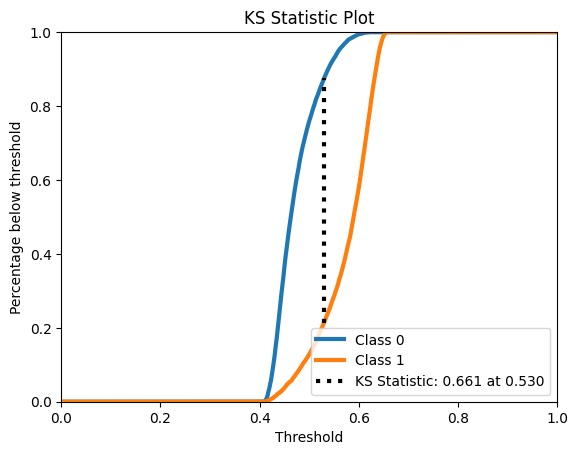

[I 2024-07-29 19:46:22,395] Trial 31 finished with values: [0.9032977765592594, 0.6609258747918875] and parameters: {'n_hidden_layers': 410, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 160, 'dropout': 40}. 




MLP
n_hidden_layers: 410
activation_function:softmax
optimizer:rmsprop
batch_size:160

Accuracy:         0.8084
Recall:           0.8717
Precision:        0.7360
F1:               0.7981
AUROC:            0.9033
AUPR:             0.9028
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8703 - loss: 0.3100 - val_accuracy: 0.9249 - val_loss: 0.1766
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9308 - loss: 0.1658 - val_accuracy: 0.9243 - val_loss: 0.1589
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9368 - loss: 0.1475 - val_accuracy: 0.9394 - val_loss: 0.1400
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9423 - loss: 0.1337 - val_accuracy: 0.9446 - val_loss: 0.1279
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9457 - loss: 0.1241 - val_accuracy: 0.9494 - val_loss: 0.1209
Epoch 6/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9488 - loss: 0.1200 - val_accuracy:

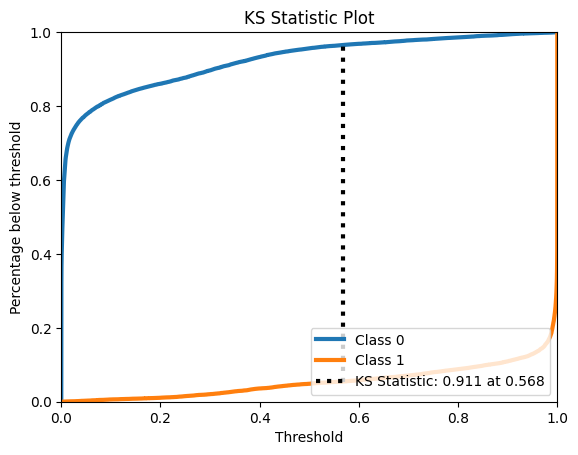

[I 2024-07-29 19:47:54,444] Trial 32 finished with values: [0.9931294452650746, 0.9107823051970744] and parameters: {'n_hidden_layers': 490, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 0}. 




MLP
n_hidden_layers: 490
activation_function:relu
optimizer:adam
batch_size:32

Accuracy:         0.9542
Recall:           0.9515
Precision:        0.9436
F1:               0.9475
AUROC:            0.9931
AUPR:             0.9919
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.7832 - loss: 0.4654 - val_accuracy: 0.8545 - val_loss: 0.3558
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.8530 - loss: 0.3741 - val_accuracy: 0.8524 - val_loss: 0.3548
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.8573 - loss: 0.3643 - val_accuracy: 0.8675 - val_loss: 0.3414
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.8613 - loss: 0.3527 - val_accuracy: 0.8698 - val_loss: 0.3353
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.8613 - loss: 0.3504 - val_accuracy: 0.8679 - val_loss: 0.3319
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step


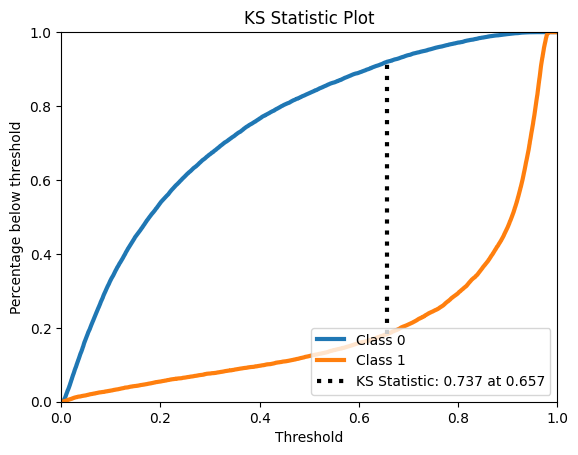

[I 2024-07-29 19:48:01,151] Trial 33 finished with values: [0.9255498718859112, 0.7369344488551397] and parameters: {'n_hidden_layers': 260, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 30}. 




MLP
n_hidden_layers: 260
activation_function:sigmoid
optimizer:rmsprop
batch_size:64

Accuracy:         0.8528
Recall:           0.8764
Precision:        0.8029
F1:               0.8381
AUROC:            0.9255
AUPR:             0.9302
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6947 - loss: 0.5808 - val_accuracy: 0.8240 - val_loss: 0.4127
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.8033 - loss: 0.4489 - val_accuracy: 0.8520 - val_loss: 0.3684
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.8264 - loss: 0.4155 - val_accuracy: 0.8623 - val_loss: 0.3457
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.8411 - loss: 0.3895 - val_accuracy: 0.8713 - val_loss: 0.3284
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8477 - loss: 0.3788 - val_accuracy: 0.8760 - val_loss: 0.3177
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step


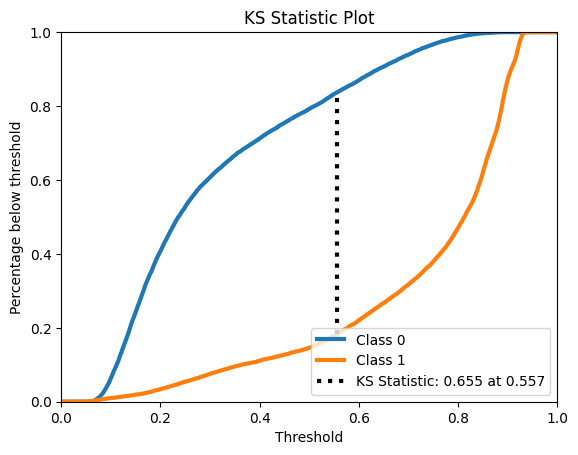

[I 2024-07-29 19:48:08,406] Trial 34 finished with values: [0.9049182672719797, 0.6547254749190321] and parameters: {'n_hidden_layers': 170, 'activation_function': 'relu', 'optimizer': 'SGD', 'batch_size': 64, 'dropout': 80}. 




MLP
n_hidden_layers: 170
activation_function:relu
optimizer:SGD
batch_size:64

Accuracy:         0.8190
Recall:           0.8540
Precision:        0.7593
F1:               0.8039
AUROC:            0.9049
AUPR:             0.9030
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8238 - loss: 0.4178 - val_accuracy: 0.8529 - val_loss: 0.3525
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.8570 - loss: 0.3672 - val_accuracy: 0.8598 - val_loss: 0.3465
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8572 - loss: 0.3619 - val_accuracy: 0.8564 - val_loss: 0.3494
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8587 - loss: 0.3648 - val_accuracy: 0.8682 - val_loss: 0.3428
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.8598 - loss: 0.3591 - val_accuracy: 0.8702 - val_loss: 0.3569
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step


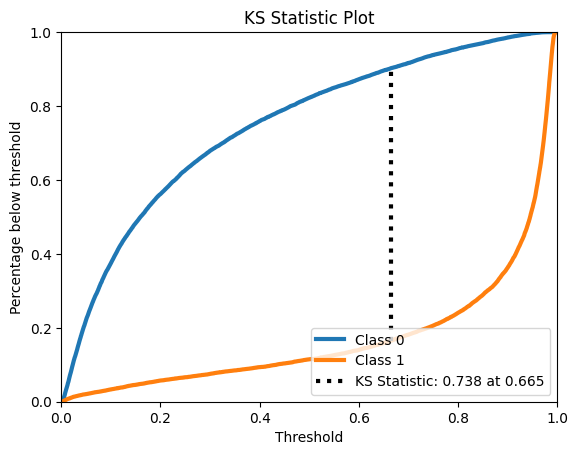

[I 2024-07-29 19:48:15,661] Trial 35 finished with values: [0.9269826783952173, 0.7376386921467998] and parameters: {'n_hidden_layers': 480, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 80}. 




MLP
n_hidden_layers: 480
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.8498
Recall:           0.8854
Precision:        0.7931
F1:               0.8367
AUROC:            0.9270
AUPR:             0.9311
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.5307 - loss: 0.7310 - val_accuracy: 0.7671 - val_loss: 0.6537
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.5735 - loss: 0.6691 - val_accuracy: 0.7949 - val_loss: 0.6386
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.6030 - loss: 0.6549 - val_accuracy: 0.7963 - val_loss: 0.6202
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6199 - loss: 0.6421 - val_accuracy: 0.8025 - val_loss: 0.6005
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.6409 - loss: 0.6255 - val_accuracy: 0.8014 - val_loss: 0.5800
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step


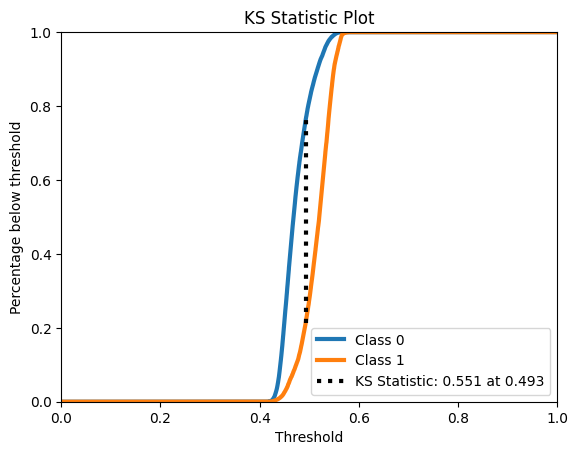

[I 2024-07-29 19:48:19,400] Trial 36 finished with values: [0.8395714445326897, 0.5505220308785777] and parameters: {'n_hidden_layers': 10, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 128, 'dropout': 60}. 




MLP
n_hidden_layers: 10
activation_function:sigmoid
optimizer:SGD
batch_size:128

Accuracy:         0.7752
Recall:           0.7237
Precision:        0.7502
F1:               0.7367
AUROC:            0.8396
AUPR:             0.7923
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.8540 - loss: 0.3492 - val_accuracy: 0.9167 - val_loss: 0.2100
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9136 - loss: 0.2116 - val_accuracy: 0.9309 - val_loss: 0.1761
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9293 - loss: 0.1701 - val_accuracy: 0.9380 - val_loss: 0.1517
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.9353 - loss: 0.1561 - val_accuracy: 0.9418 - val_loss: 0.1423
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9406 - loss: 0.1435 - val_accuracy: 0.9440 - val_loss: 0.1329
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


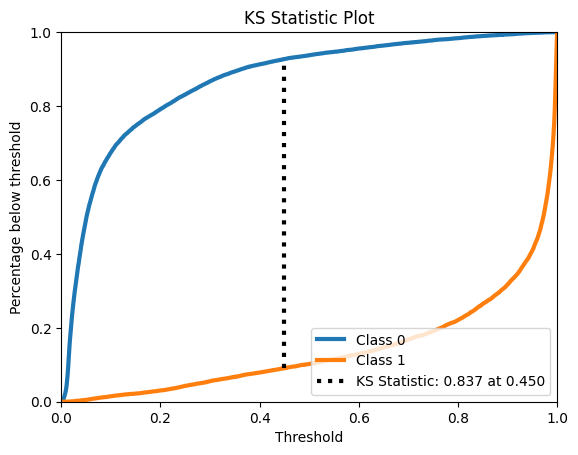

[I 2024-07-29 19:48:28,022] Trial 37 finished with values: [0.9746655702317559, 0.8370770018384436] and parameters: {'n_hidden_layers': 280, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 10}. 




MLP
n_hidden_layers: 280
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.9203
Recall:           0.8978
Precision:        0.9170
F1:               0.9073
AUROC:            0.9747
AUPR:             0.9715
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7963 - loss: 0.4528 - val_accuracy: 0.8671 - val_loss: 0.3499
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - accuracy: 0.8599 - loss: 0.3561 - val_accuracy: 0.8677 - val_loss: 0.3433
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 821us/step - accuracy: 0.8635 - loss: 0.3527 - val_accuracy: 0.8664 - val_loss: 0.3423
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8658 - loss: 0.3479 - val_accuracy: 0.8713 - val_loss: 0.3494
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8658 - loss: 0.3507 - val_accuracy: 0.8650 - val_loss: 0.3420
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


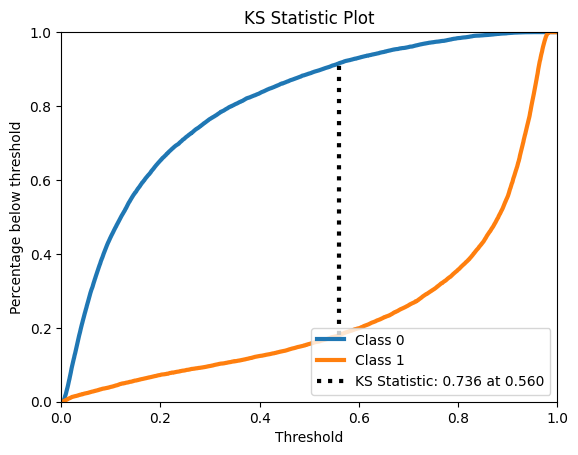

[I 2024-07-29 19:48:49,133] Trial 38 finished with values: [0.9257695792553593, 0.7363123412881147] and parameters: {'n_hidden_layers': 380, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 32, 'dropout': 30}. 




MLP
n_hidden_layers: 380
activation_function:tanh
optimizer:SGD
batch_size:32

Accuracy:         0.8689
Recall:           0.8440
Precision:        0.8527
F1:               0.8483
AUROC:            0.9258
AUPR:             0.9296
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7376 - loss: 0.5254 - val_accuracy: 0.8743 - val_loss: 0.3163
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8675 - loss: 0.3350 - val_accuracy: 0.9004 - val_loss: 0.2580
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8894 - loss: 0.2857 - val_accuracy: 0.9118 - val_loss: 0.2313
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.2604 - val_accuracy: 0.9202 - val_loss: 0.2068
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9029 - loss: 0.2491 - val_accuracy: 0.9238 - val_loss: 0.1954
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step


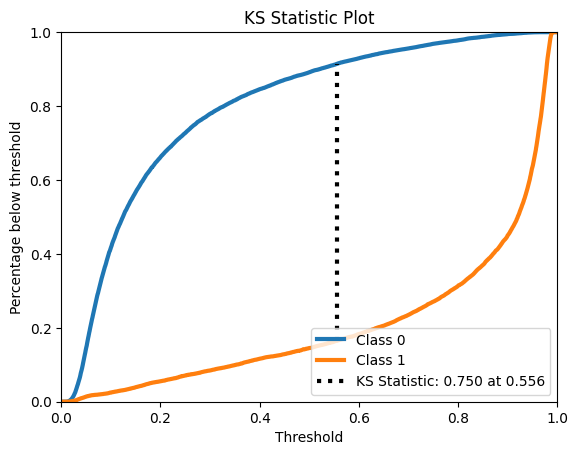

[I 2024-07-29 19:49:08,261] Trial 39 finished with values: [0.9373872851049359, 0.7498535641281956] and parameters: {'n_hidden_layers': 70, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 128, 'dropout': 60}. 




MLP
n_hidden_layers: 70
activation_function:relu
optimizer:adam
batch_size:128

Accuracy:         0.8755
Recall:           0.8549
Precision:        0.8581
F1:               0.8565
AUROC:            0.9374
AUPR:             0.9385
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7458 - loss: 0.5170 - val_accuracy: 0.8489 - val_loss: 0.3684
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.8455 - loss: 0.3728 - val_accuracy: 0.8640 - val_loss: 0.3373
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8618 - loss: 0.3460 - val_accuracy: 0.8746 - val_loss: 0.3230
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.8678 - loss: 0.3315 - val_accuracy: 0.8780 - val_loss: 0.3099
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.8743 - loss: 0.3201 - val_accuracy: 0.8835 - val_loss: 0.2982
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


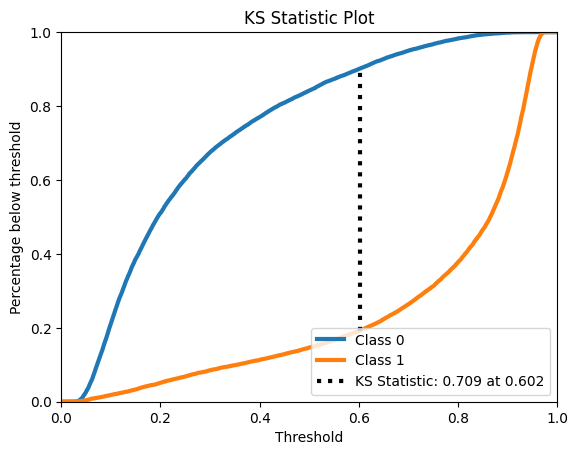

[I 2024-07-29 19:49:15,354] Trial 40 finished with values: [0.919363438599122, 0.7093783050610526] and parameters: {'n_hidden_layers': 260, 'activation_function': 'relu', 'optimizer': 'SGD', 'batch_size': 64, 'dropout': 30}. 




MLP
n_hidden_layers: 260
activation_function:relu
optimizer:SGD
batch_size:64

Accuracy:         0.8469
Recall:           0.8535
Precision:        0.8057
F1:               0.8289
AUROC:            0.9194
AUPR:             0.9222
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8424 - loss: 0.3838 - val_accuracy: 0.8582 - val_loss: 0.3813
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.8636 - loss: 0.3531 - val_accuracy: 0.8663 - val_loss: 0.3313
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step - accuracy: 0.8698 - loss: 0.3375 - val_accuracy: 0.8765 - val_loss: 0.3015
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.8777 - loss: 0.3033 - val_accuracy: 0.9021 - val_loss: 0.2510
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 850us/step - accuracy: 0.8842 - loss: 0.2791 - val_accuracy: 0.9072 - val_loss: 0.2340
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step


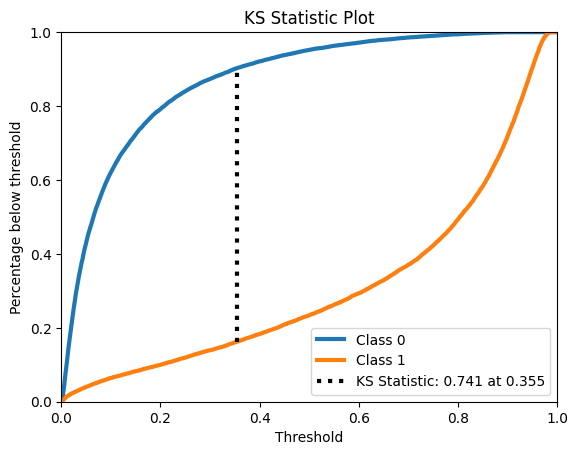

[I 2024-07-29 19:49:27,222] Trial 41 finished with values: [0.926895597618965, 0.7406643032562593] and parameters: {'n_hidden_layers': 340, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 20}. 




MLP
n_hidden_layers: 340
activation_function:tanh
optimizer:rmsprop
batch_size:32

Accuracy:         0.8713
Recall:           0.7661
Precision:        0.9247
F1:               0.8380
AUROC:            0.9269
AUPR:             0.9309
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7755 - loss: 0.4812 - val_accuracy: 0.8479 - val_loss: 0.4160
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8516 - loss: 0.3713 - val_accuracy: 0.8415 - val_loss: 0.3643
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8548 - loss: 0.3669 - val_accuracy: 0.8649 - val_loss: 0.3736
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8578 - loss: 0.3642 - val_accuracy: 0.8320 - val_loss: 0.3769
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8582 - loss: 0.3598 - val_accuracy: 0.8681 - val_loss: 0.3444
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


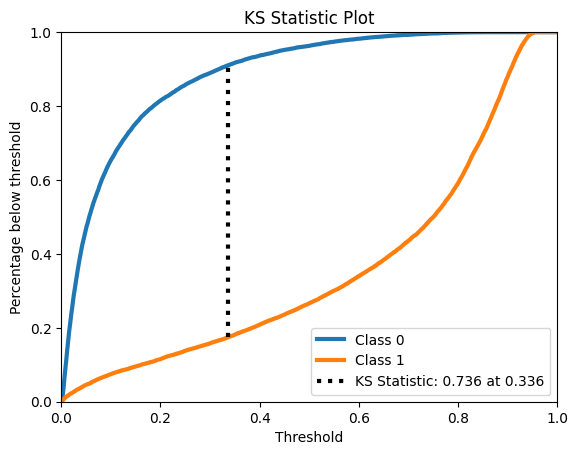

[I 2024-07-29 19:49:41,805] Trial 42 finished with values: [0.9250977470904577, 0.736227236988387] and parameters: {'n_hidden_layers': 410, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 160, 'dropout': 10}. 




MLP
n_hidden_layers: 410
activation_function:sigmoid
optimizer:rmsprop
batch_size:160

Accuracy:         0.8633
Recall:           0.7337
Precision:        0.9382
F1:               0.8235
AUROC:            0.9251
AUPR:             0.9302
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8219 - loss: 0.4176 - val_accuracy: 0.8452 - val_loss: 0.3596
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 7s 966us/step - accuracy: 0.8560 - loss: 0.3637 - val_accuracy: 0.8581 - val_loss: 0.3503
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8578 - loss: 0.3620 - val_accuracy: 0.8672 - val_loss: 0.3469
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.8587 - loss: 0.3627 - val_accuracy: 0.8715 - val_loss: 0.3507
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8595 - loss: 0.3609 - val_accuracy: 0.8678 - val_loss: 0.3413
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step


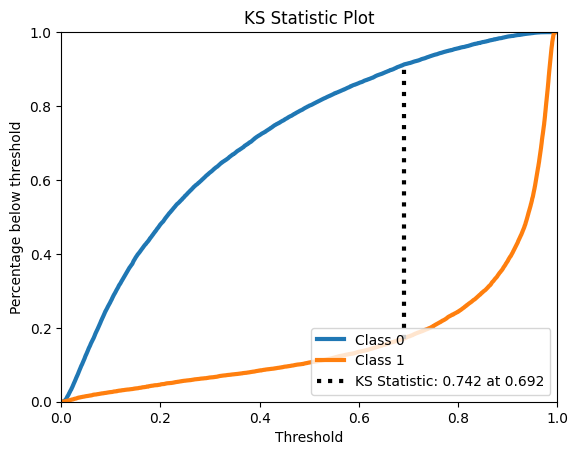

[I 2024-07-29 19:50:06,121] Trial 43 finished with values: [0.9264953804242684, 0.7418348637573233] and parameters: {'n_hidden_layers': 450, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 80}. 




MLP
n_hidden_layers: 450
activation_function:tanh
optimizer:adam
batch_size:32

Accuracy:         0.8413
Recall:           0.8939
Precision:        0.7752
F1:               0.8303
AUROC:            0.9265
AUPR:             0.9311
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6369 - loss: 0.6338 - val_accuracy: 0.8202 - val_loss: 0.4314
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.7856 - loss: 0.4755 - val_accuracy: 0.8383 - val_loss: 0.4030
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.8091 - loss: 0.4401 - val_accuracy: 0.8365 - val_loss: 0.3837
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8194 - loss: 0.4251 - val_accuracy: 0.8300 - val_loss: 0.3838
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8276 - loss: 0.4125 - val_accuracy: 0.8548 - val_loss: 0.3689
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step


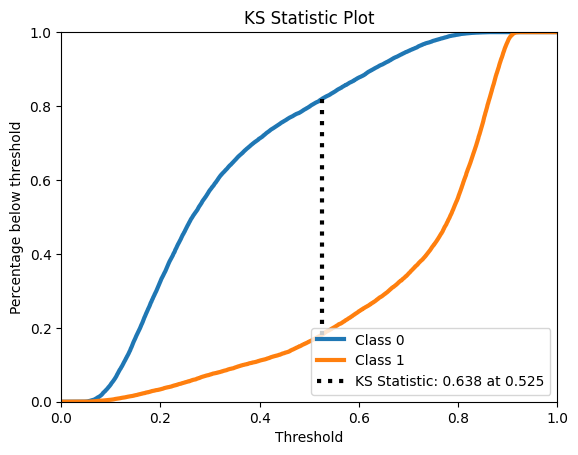

[I 2024-07-29 19:50:19,000] Trial 44 finished with values: [0.8983796486443161, 0.638244100417345] and parameters: {'n_hidden_layers': 460, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 32, 'dropout': 30}. 




MLP
n_hidden_layers: 460
activation_function:sigmoid
optimizer:SGD
batch_size:32

Accuracy:         0.8151
Recall:           0.8372
Precision:        0.7611
F1:               0.7974
AUROC:            0.8984
AUPR:             0.8976
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7626 - loss: 0.4944 - val_accuracy: 0.8608 - val_loss: 0.3570
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8518 - loss: 0.3774 - val_accuracy: 0.8626 - val_loss: 0.3499
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8569 - loss: 0.3651 - val_accuracy: 0.8581 - val_loss: 0.3501
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8576 - loss: 0.3634 - val_accuracy: 0.8661 - val_loss: 0.3436
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8580 - loss: 0.3613 - val_accuracy: 0.8655 - val_loss: 0.3403
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


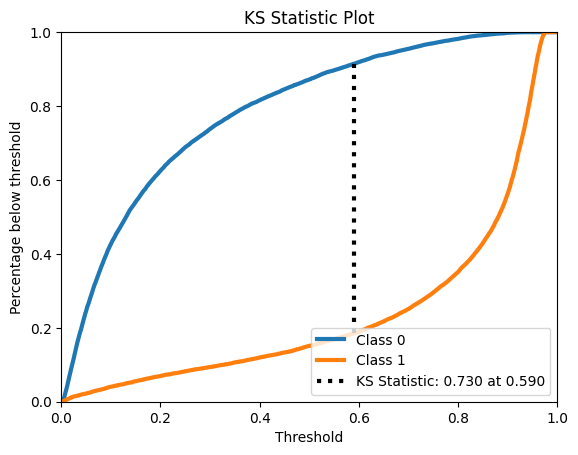

[I 2024-07-29 19:50:25,477] Trial 45 finished with values: [0.9239834119420895, 0.7297926014855359] and parameters: {'n_hidden_layers': 190, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 20}. 




MLP
n_hidden_layers: 190
activation_function:sigmoid
optimizer:adam
batch_size:160

Accuracy:         0.8619
Recall:           0.8492
Precision:        0.8357
F1:               0.8424
AUROC:            0.9240
AUPR:             0.9283
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.7840 - loss: 0.4639 - val_accuracy: 0.8619 - val_loss: 0.3509
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.8513 - loss: 0.3716 - val_accuracy: 0.8663 - val_loss: 0.3461
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8560 - loss: 0.3604 - val_accuracy: 0.8599 - val_loss: 0.3463
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8628 - loss: 0.3486 - val_accuracy: 0.8706 - val_loss: 0.3361
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8633 - loss: 0.3481 - val_accuracy: 0.8700 - val_loss: 0.3402
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step


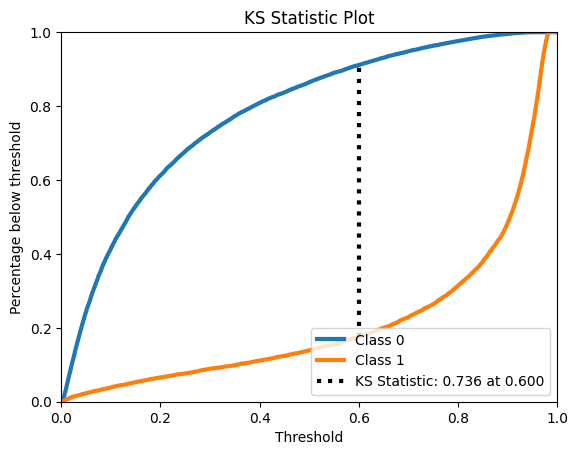

[I 2024-07-29 19:50:34,211] Trial 46 finished with values: [0.9257232304948277, 0.7357136773576791] and parameters: {'n_hidden_layers': 230, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 20}. 




MLP
n_hidden_layers: 230
activation_function:sigmoid
optimizer:rmsprop
batch_size:64

Accuracy:         0.8628
Recall:           0.8609
Precision:        0.8297
F1:               0.8450
AUROC:            0.9257
AUPR:             0.9301
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4588 - loss: 0.6945 - val_accuracy: 0.4525 - val_loss: 0.6938
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.4769 - loss: 0.6936 - val_accuracy: 0.4735 - val_loss: 0.6929
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5263 - loss: 0.6927 - val_accuracy: 0.5124 - val_loss: 0.6921
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.5717 - loss: 0.6919 - val_accuracy: 0.6526 - val_loss: 0.6912
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.6042 - loss: 0.6911 - val_accuracy: 0.7018 - val_loss: 0.6904
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step


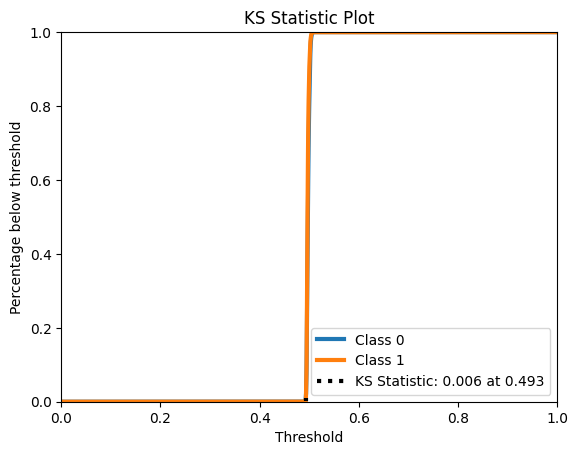

[I 2024-07-29 19:50:38,133] Trial 47 finished with values: [0.42833522914877, 0.006427443753309464] and parameters: {'n_hidden_layers': 60, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 160, 'dropout': 10}. 




MLP
n_hidden_layers: 60
activation_function:softmax
optimizer:SGD
batch_size:160

Accuracy:         0.5010
Recall:           0.1000
Precision:        0.2869
F1:               0.1482
AUROC:            0.4283
AUPR:             0.3754
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8425 - loss: 0.3702 - val_accuracy: 0.9037 - val_loss: 0.2385
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step - accuracy: 0.9055 - loss: 0.2339 - val_accuracy: 0.9267 - val_loss: 0.1844
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9191 - loss: 0.1994 - val_accuracy: 0.9322 - val_loss: 0.1688
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.9264 - loss: 0.1821 - val_accuracy: 0.9374 - val_loss: 0.1568
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - accuracy: 0.9300 - loss: 0.1690 - val_accuracy: 0.9416 - val_loss: 0.1454
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step


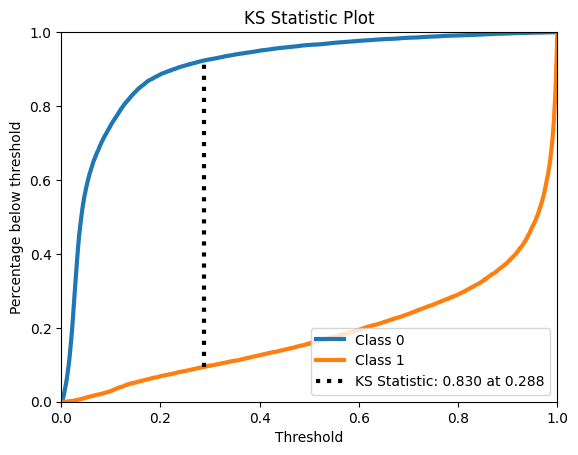

[I 2024-07-29 19:50:50,936] Trial 48 finished with values: [0.9711335217556272, 0.8295028195306192] and parameters: {'n_hidden_layers': 220, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 50}. 




MLP
n_hidden_layers: 220
activation_function:relu
optimizer:rmsprop
batch_size:32

Accuracy:         0.9121
Recall:           0.8428
Precision:        0.9491
F1:               0.8928
AUROC:            0.9711
AUPR:             0.9682
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8365 - loss: 0.3876 - val_accuracy: 0.8651 - val_loss: 0.3652
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8616 - loss: 0.3523 - val_accuracy: 0.8618 - val_loss: 0.3412
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8638 - loss: 0.3470 - val_accuracy: 0.8755 - val_loss: 0.3240
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8698 - loss: 0.3286 - val_accuracy: 0.8904 - val_loss: 0.2847
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8841 - loss: 0.2907 - val_accuracy: 0.9013 - val_loss: 0.2528
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step


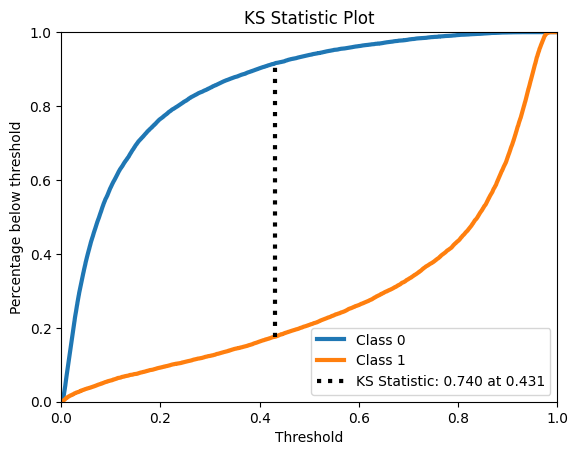

[I 2024-07-29 19:50:59,962] Trial 49 finished with values: [0.9273460586226566, 0.7400425739991943] and parameters: {'n_hidden_layers': 430, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64, 'dropout': 10}. 




MLP
n_hidden_layers: 430
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.8747
Recall:           0.7922
Precision:        0.9078
F1:               0.8460
AUROC:            0.9273
AUPR:             0.9313


In [101]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=50)

#### Salvando os resultados no csv e visualizando os resultados

In [103]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "../results/optuna_results_mlp.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [104]:
df_existing

,number,values_0,values_1,params_activation_function,params_batch_size,params_n_hidden_layers,params_optimizer,user_attrs_accuracy,user_attrs_activation_function,user_attrs_auroc,...,user_attrs_f1,user_attrs_ks_statistic,user_attrs_max_distance_at,user_attrs_n_hidden_layers,user_attrs_optimizer,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation,params_dropout,user_attrs_dropout
0,10,0.431994,0.045550,softmax,64,220,SGD,0.950724,softmax,0.431994,...,0.948055,0.045550,0.500170,220,SGD,0.948055,0.937974,0,NaN,NaN
1,3,0.463689,0.050850,softmax,64,280,SGD,0.950724,softmax,0.463689,...,0.948055,0.050850,0.499692,280,SGD,0.948055,0.937974,0,NaN,NaN
2,37,0.675989,0.266699,softmax,64,180,SGD,0.950724,softmax,0.675989,...,0.948055,0.266699,0.500848,180,SGD,0.948055,0.937974,0,NaN,NaN
3,39,0.820313,0.506949,softmax,64,40,SGD,0.950724,softmax,0.820313,...,0.948055,0.506949,0.505659,40,SGD,0.948055,0.937974,0,NaN,NaN
4,46,0.837507,0.532143,sigmoid,128,320,SGD,0.950724,sigmoid,0.837507,...,0.948055,0.532143,0.496873,320,SGD,0.948055,0.937974,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,48,0.971134,0.829503,relu,32,220,rmsprop,0.912103,relu,0.971134,...,0.949150,0.829503,0.287831,220,rmsprop,0.949150,0.842844,0,50.0,50.0
146,28,0.973028,0.836689,relu,32,430,rmsprop,0.917093,relu,0.973028,...,0.936253,0.836689,0.342205,430,rmsprop,0.936253,0.868292,0,60.0,60.0
147,37,0.974666,0.837077,relu,64,280,rmsprop,0.920296,relu,0.974666,...,0.917023,0.837077,0.449727,280,rmsprop,0.917023,0.897781,0,10.0,10.0
148,12,0.976973,0.844720,relu,32,200,rmsprop,0.916662,relu,0.976973,...,0.952169,0.844720,0.307023,200,rmsprop,0.952169,0.850925,0,20.0,20.0


In [105]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9542038805050816
  Precision: 0.9435540559538872
  Recall:    0.9515134330474233
  F1 Score:  0.9435540559538872
  auroc:  0.9931294452650746
  ks_statistic:  0.9107823051970744
  max_distance_at:  0.5679817795753479
  Parameters: 
    n_hidden_layers:  490
    activation_function: relu
    optimizer:        adam
    batch_size:       32
    dropout:          0

-- Overall Results (Ordered by auroc) --
    number  values_0  values_1 params_activation_function  params_batch_size  \
4        4  0.361040  0.000044                    softmax                128   
47      47  0.428335  0.006427                    softmax                160   
36      36  0.839571  0.550522                    sigmoid                128   
0        0  0.882170  0.602708                    sigmoid                160   
29      29  0.883048  0.607662                    sigmoid                160   
17      17  0.883685  0.613437                    sigmoid                128   
5